In [15]:
import warnings
warnings.filterwarnings('ignore')

import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator() 

import tensorflow as tf
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
import random
size = (120, 120) 


In [2]:
data=pd.read_csv('100k.txt',header=None)
data

,0
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...
...,...
99995,Cc1nc(C[NH+]2CCC[C@@H]2c2c(C)n[nH]c2C)sc1C
99996,CC(C)(O)CNC(=O)NCCCCC1CCCC1
99997,Cc1c(CCC(=O)NCCN2CCOCC2)c(=O)oc2cc3oc4c(c3cc12...
99998,C=CCC[C@H](C)OC(=O)c1sc(-c2c(C)c(C)nn(C)c2=O)nc1C


In [3]:
x=[]
for i in range(100000):
    for j in range(5):
        x.append(sme.randomize_smiles(data.iloc[i,0]))

In [4]:
target=[]
for i in range(100000):
    for j in range(5):
        target.append(data.iloc[i,0])

In [5]:
summa=[]
summa.append(x)
summa.append(target)
summa=np.array(summa).T
dataset=pd.DataFrame(summa)
dataset

,0,1
0,C(Nc1ccccc1F)(Cc1c2c(oc1)ccc(C(C)(C)C)c2)=O,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
1,c1cccc(F)c1NC(=O)Cc1coc2ccc(C(C)(C)C)cc21,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
2,c1(NC(=O)Cc2coc3c2cc(C(C)(C)C)cc3)c(F)cccc1,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
3,c1(C(C)(C)C)cc2c(cc1)occ2CC(Nc1c(F)cccc1)=O,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
4,c1c(F)c(NC(Cc2coc3ccc(C(C)(C)C)cc32)=O)ccc1,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
...,...,...
499995,C1(=O)[C@](C)(c2ccc(C#N)cc2)NC(=O)N1Cc1nc(CCC(...,CC(C)CCc1nc(CN2C(=O)N[C@@](C)(c3ccc(C#N)cc3)C2...
499996,C[C@]1(c2ccc(C#N)cc2)C(=O)N(Cc2csc(CCC(C)C)n2)...,CC(C)CCc1nc(CN2C(=O)N[C@@](C)(c3ccc(C#N)cc3)C2...
499997,C(C)(CCc1scc(CN2C(=O)N[C@@](C)(c3ccc(C#N)cc3)C...,CC(C)CCc1nc(CN2C(=O)N[C@@](C)(c3ccc(C#N)cc3)C2...
499998,c1c([C@]2(C)NC(=O)N(Cc3csc(CCC(C)C)n3)C2=O)ccc...,CC(C)CCc1nc(CN2C(=O)N[C@@](C)(c3ccc(C#N)cc3)C2...


In [2]:
from transformers import  AutoTokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("rifkat/pubchem_1M")

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/503k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357k [00:00<?, ?B/s]

In [8]:
from sklearn import model_selection
def Train_Test(x):
    train_data, ts_data = model_selection.train_test_split(x,shuffle=True, test_size = 0.2)
    def Train_Test1(x):
        tr_data, te_data = model_selection.train_test_split(x,shuffle=True, test_size = 0.5)
        return tr_data, te_data
    valid_data, test_data = Train_Test1(ts_data)
    return train_data, valid_data, test_data

In [9]:
train_df, valid_df, test_df = Train_Test(dataset)

In [15]:
ds_x=tf.ragged.constant(np.array(train_df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True))))).to_tensor().numpy()
ds_y=tf.ragged.constant(np.array(train_df[1].apply((lambda x: tokenizer.encode(x, add_special_tokens=True))))).to_tensor().numpy()


In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [11]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = angle_rads[np.newaxis, ...]
  
    return tf.cast(pos_encoding, dtype=tf.float32)

In [13]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [15]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [17]:
def scaled_dot_product_attention(q, k, v, mask):
      
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
  
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
  
    return output, attention_weights

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
  
        assert d_model % self.num_heads == 0
  
        self.depth = d_model // self.num_heads
  
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
  
        self.dense = tf.keras.layers.Dense(d_model)
  
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
  
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
    
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
    
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
    
        return output, attention_weights

In [25]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
  
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
  
        return out2

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
      # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [31]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [32]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
  
        self.d_model = d_model
        self.num_layers = num_layers
  
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
  
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
  
    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
  
        seq_len = tf.shape(x)[1]
        attention_weights = {}
  
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
  
        x = self.dropout(x, training=training)
  
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
  
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
  
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
  
        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)
  
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
  
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [37]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
  
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
  
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [39]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

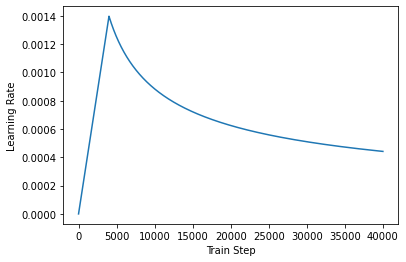

In [40]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [41]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [42]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
#     print(real,'loss_function')
#     print(pred,'loss_function')
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
#     print(real,'accuracy_function')
#     print(pred,'accuracy_function')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [44]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.vocab_size,
    target_vocab_size=tokenizer.vocab_size,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [45]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [46]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [52]:
EPOCHS = 10


In [53]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                   True,
                                   enc_padding_mask,
                                   combined_mask,
                                   dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [54]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> nocanonic, tar -> canonic
    i=0
    batch = 0
    X=[]
    Y=[]
    while True:
        i=i+64   
        if i>=ds_x.shape[0]:
            break
        inp = tf.ragged.constant(ds_x[i:i+64],dtype=tf.int64).to_tensor()
        tar = tf.ragged.constant(ds_y[i:i+64],dtype=tf.int64).to_tensor()    
        train_step(inp, tar)
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        batch = batch + 1

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [47]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
    sentence = tf.ragged.constant(np.array(tokenizer.encode(sentence, add_special_tokens=True)).reshape(1,-1),dtype=tf.int64).to_tensor()
  
    encoder_input = sentence
  
    # as the target is english, the first word to the transformer should be the
    # english start token.
    end = tf.ragged.constant(2,dtype=tf.int64)
#     output = tf.convert_to_tensor([start])
    output = tf.ragged.constant(np.array(0).reshape(1,-1),dtype=tf.int64).to_tensor()
  
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
  
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
  
        predicted_id = tf.argmax(predictions, axis=-1)
  
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
  
        # return the result if the predicted_id is equal to the end token
        if predicted_id == end:
            break
  
    pred=''
    keys = pd.DataFrame(tokenizer.vocab.keys())
    values = pd.DataFrame(tokenizer.vocab.values())
    dic = dict()
    for i in range(keys.shape[0]):
        dic[values.iloc[i,0]]=(keys.iloc[i,0])
    for j in range (output.numpy().shape[1]):
        if output.numpy()[0,j] != 0 and output.numpy()[0,j] != 2:
            pred=pred+dic[output.numpy()[0,j]]
    return pred

In [72]:
def check_smi(smi):
    m = Chem.MolFromSmiles(smi,sanitize=False)
    if m is None:
        return 'invalid SMILES'
    else:
        try:
            Chem.SanitizeMol(m)
            return True
        except:
            return 'invalid chemistry'

In [50]:
def similarity(real,pred):
    ref = Chem.MolFromSmiles(real)
    mol1 = Chem.MolFromSmiles(pred)
    fp1 = Chem.RDKFingerprint(ref)
    fp2 = Chem.RDKFingerprint(mol1)

    Tan  =DataStructs.TanimotoSimilarity(fp1,fp2)
    return Tan

In [16]:
def draw(smi):
    print(smi)
    m = Chem.MolFromSmiles(smi)
    fig = Draw.MolToMPL(m, size=size) 

In [77]:
pred_smi=[]
for i in range(10):
    try:
        row=[]
#         print("Haqiqiy smiles:",test_df.iloc[i,0])
#         m = Chem.MolFromSmiles(test_df.iloc[i,0])
#         fig = Draw.MolToMPL(m, size=size)    
        sentence = test_df.iloc[random.randint(0,50000),0]
        pred = evaluate(sentence)
        row.append(sentence)
        row.append(pred)
        check=check_smi(pred)
        if check == True:
            row.append(True)
            row.append(similarity(sentence,pred))
        else:
            row.append(check)
            row.append(0)
        pred_smi.append(row)
#         print("Bashorat smiles:",pred)
#         pred_smi.append(pred)
#         m = Chem.MolFromSmiles(pred)
#         fig = Draw.MolToMPL(m, size=size) 
#         print()
    except Exception as ex:
        pass

RDKit ERROR: [17:51:22] SMILES Parse Error: unclosed ring for input: 'C[C@H](Nc1c(C#N)c(=O)n(C)c(=O)n1C)c1ccc(OC(C)C)'
RDKit ERROR: [17:51:33] SMILES Parse Error: unclosed ring for input: '[NH3+]COc1cc(CNC(=O)C(C)C)ccc1OC1'


In [12]:
pd.DataFrame(pred_smi).to_excel('pred_smi.xlsx',index=False)

In [13]:
pred_smi=pd.read_excel('pred_smi.xlsx')
pred_smi

,Real,Pred,check,Similarity
0,N(C(=O)C)c1ccc(CNC(=O)CNC(=O)c2c(OC)cccc2)cc1,CNC(=O)Nc1ccc(CNC(=O)CNC(=O)c2ccccc2OC)cc1,True,0.881443
1,C(n1nc(N)cc1C)Oc1ccc(Cl)cc1Cl,c1cc(N)nn1COc1ccc(Cl)cc1Cl,True,0.797732
2,Cn1c(=O)c(C#N)c(N[C@H](c2ccc(OC(C)C)cc2)C)n(C)...,C[C@H](Nc1c(C#N)c(=O)n(C)c(=O)n1C)c1ccc(OC(C)C),invalid SMILES,0.000000
3,O=S(=O)(N[C@@H]1CCCC[C@H]1O)c1cc(N)c(Cl)cc1C,c1cc(Cl)c(N)cc1S(=O)(=O)N[C@@H]1CCCC[C@@H]1O,True,0.777624
4,c1(C)nc2ccc(NCC(NC(=O)NC)=O)cc2s1,C=C(CNC(=O)Nc1ccc2nc(C)sc2c1)NC(=O)NC,True,0.702156
5,C1[C@@H](COc2c(OC)cc(CNC(=O)C(C)C)cc2)OCC1,[NH3+]COc1cc(CNC(=O)C(C)C)ccc1OC1,invalid SMILES,0.000000
6,C([NH2+][C@@H]1C[C@H](COC)CCC1)C,[NH2+][C@H]1CCC[C@@H](COC)C1,True,0.709677
7,C(N(C(N1CCC(OCC([O-])=O)CC1)=O)CC)C(O)(C)C,N/C(=O)N1CCC(OCC(=O)[O-])CC1,True,0.651351
8,c1cccc2c1SC[C@H]2C[NH2+]C[C@@H](C)CCCl,[NH2+]C[C@H](CCCl)C[C@H]1CSc2ccccc21,True,0.538462
9,C(c1c(C)c(NC(CSc2nc(C)n[nH]2)=O)ccc1)SC(C)C,c1n[nH]c(SCC(=O)Nc2cccc(CSC(C)C)c2C)n1,True,0.922099


CNC(=O)Nc1ccc(CNC(=O)CNC(=O)c2ccccc2OC)cc1
c1cc(N)nn1COc1ccc(Cl)cc1Cl
c1cc(Cl)c(N)cc1S(=O)(=O)N[C@@H]1CCCC[C@@H]1O
C=C(CNC(=O)Nc1ccc2nc(C)sc2c1)NC(=O)NC
[NH2+][C@H]1CCC[C@@H](COC)C1
N/C(=O)N1CCC(OCC(=O)[O-])CC1
[NH2+]C[C@H](CCCl)C[C@H]1CSc2ccccc21
c1n[nH]c(SCC(=O)Nc2cccc(CSC(C)C)c2C)n1


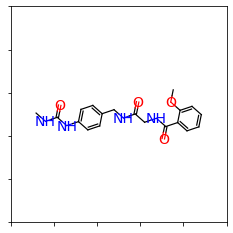

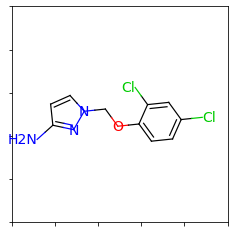

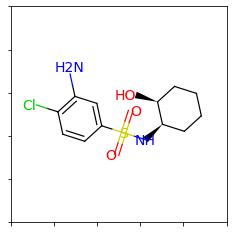

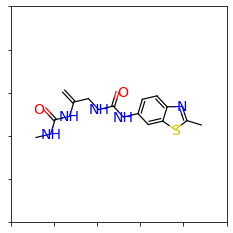

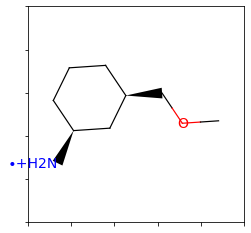

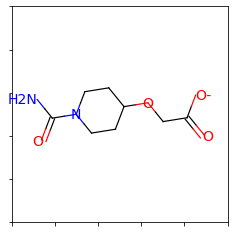

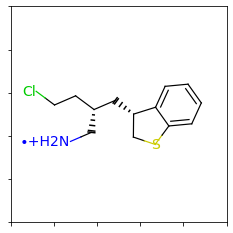

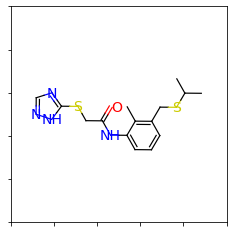

In [18]:
for i in range(10):
    if pred_smi.iloc[i,2]==True:
        draw(pred_smi.iloc[i,1])
